In [1]:
import os

import xarray as xr
import numpy as np
import shutil
import random
import string

import matplotlib.pyplot as plt
import cmocean
from matplotlib.patches import Circle
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import  BoundaryNorm
from matplotlib import colormaps

import functools
from scipy import stats
import dask
import dask.array as da
from dask.distributed import Client
dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}proxy/{port}/status'})

In [2]:
eeb = [95, 145, 76, 87.5]
web = [-10, 95, 80, 87.5]

In [3]:
SMALL_SIZE = 8
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=SMALL_SIZE)  # fontsize of the figure title

In [4]:
#define regular mesh in multiples of R
reg_x = np.arange(-3.1,3.2,.1)
reg_y = np.arange(-3,3.1,.1)
X,Y = np.meshgrid(reg_x,reg_y)

In [5]:
# Define your custom preprocessing function
def preprocess(ds,var,cyc=None,ice_min=0,ice_max=1,rad_min=0,rad_max=99999,region=None,warm_core=None):
    # Filter the dataset
    if region:
        lon_min=region[0]
        lon_max=region[1]
        lat_min=region[2]
        lat_max=region[3]
    else:
        lon_min=-9999
        lon_max=9999
        lat_min=-9999
        lat_max=9999
    if warm_core==True:
        temp_indexer = ds['warm_index'] #take only warm ones
    elif warm_core==False:
        temp_indexer = ~ds['warm_index'] #swap true and false -> ake only cold ones
    elif warm_core==None:
        temp_indexer = (ds['warm_index']|~ds['warm_index']) #all true -> take all eddies

    cyc_indexer = ds['cyc'] == cyc
    rad_indexer = (ds['rad'] >= rad_min) & (ds['rad'] <= rad_max)
    ice_indexer = (ds['ice_avg'] >= ice_min) & (ds['ice_avg'] <= ice_max)
    lon_indexer = (ds['lon'] >= lon_min) & (ds['lon'] <= lon_max)
    lat_indexer = (ds['lat'] >= lat_min) & (ds['lat'] <= lat_max)
    indexer = (cyc_indexer&rad_indexer&ice_indexer&lon_indexer&lat_indexer&temp_indexer).compute()  # Compute the indexer
    ds = ds.where(indexer, drop=True)
    # indexer = (ds['cyc'] == cyc).compute()  # Compute the indexer
    # ds = ds.where(indexer, drop=True)
    # indexer = ((ds['rad'] >= rad_min) & (ds['rad'] <= rad_max)).compute()  # Compute the indexer
    # ds = ds.where(indexer, drop=True)
    # indexer = ((ds['ice_avg'] >= ice_min) & (ds['ice_avg'] <= ice_max)).compute()  # Compute the indexer
    # ds = ds.where(indexer, drop=True)
    # indexer = ((ds['lon'] >= lon_min) & (ds['lon'] <= lon_max)).compute()  # Compute the indexer
    # ds = ds.where(indexer, drop=True)
    # indexer = ((ds['lat'] >= lat_min) & (ds['lat'] <= lat_max)).compute()  # Compute the indexer
    # ds = ds.where(indexer, drop=True)
    
    # Store the length of the 'ee' dimension as a new variable
    ds['num_eddies'] = len(ds['ee'])
    ds['sum'] = ds[var].sum(dim='ee', skipna=True)
    ds['square_sum'] = (ds[var]**2).sum(dim='ee', skipna=True)


    #drop the variables that have 'ee' dimension
    ds = ds.drop_vars(var)
    ds = ds.drop_vars('num')
    ## Calculate the mean along the 'ee' dimension
    ds = ds.mean(dim='ee')
    return ds

# Define your custom boundaries
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    #base = plt.cm.get_cmap(base_cmap)
    base = colormaps.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    #return base.from_list(cmap_name, color_list, N)
    return LinearSegmentedColormap.from_list(cmap_name, color_list, N)

def limits_for_levels(number):
    if number == 0:
        return 0  # Handle special case

    # Find the order of magnitude of the number
    order_of_magnitude = np.floor(np.log10(np.abs(number)))
    # Calculate the adjustment factor
    adjustment_factor = 5 * (10 ** (order_of_magnitude - 1))
    # Round the number to the next larger factor of 5
    rounded_number = np.ceil(number / adjustment_factor) * adjustment_factor
    # Ensure the sign is preserved
    if number < 0:
        rounded_number *= -1
    # Round the result to appropriate decimal places based on order of magnitude
    decimal_places = max(0, -int(order_of_magnitude) + 1)  # Ensure at least one decimal place
    rounded_number = np.round(rounded_number, decimal_places)
    
    n = int(1+(20*rounded_number/(10**order_of_magnitude)))
    return rounded_number, n



In [6]:
def generate_random_string(length):
    # Define the characters to choose from
    characters = string.ascii_letters + string.digits  # You can add more characters if needed
    # Use random.choices to generate a list of random characters
    random_characters = random.choices(characters, k=length)
    # Join the characters into a string
    random_string = ''.join(random_characters)
    return random_string
#spawn a parallel cluster
n_cores = 20
mem_lim = str(int(100*np.floor(960/n_cores)))+'MB' #96GB total memory, set to MB (96000), divide by number of cores, then round to next 100
dask_dir = '/p/scratch/chhb19/mueller29/dask_dir/'+generate_random_string(10)
if os.path.exists(dask_dir):
    shutil.rmtree(dask_dir)
if 'client' in locals() or 'client' in globals():
    client.close()
client = Client(local_directory=dask_dir,n_workers=n_cores, threads_per_worker=1,memory_limit=mem_lim)
client.amm.start()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/vasco.mueller_at_awi.de/xdaf770f02c4451a8e26967580f03894/proxy/8787/status,
Dashboard: /user/vasco.mueller_at_awi.de/xdaf770f02c4451a8e26967580f03894/proxy/8787/status,Workers: 20
Total threads: 20,Total memory: 89.41 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36923,Workers: 20
Dashboard: /user/vasco.mueller_at_awi.de/xdaf770f02c4451a8e26967580f03894/proxy/8787/status,Total threads: 20
Started: Just now,Total memory: 89.41 GiB
Comm: tcp://127.0.0.1:35281,Total threads: 1
Dashboard: /user/vasco.mueller_at_awi.de/xdaf770f02c4451a8e26967580f03894/proxy/33499/status,Memory: 4.47 GiB
Nanny: tcp://127.0.0.1:35715,


In [7]:
plot_path  = '/p/home/jusers/mueller29/juwels/EPICA/plots/composites/'
composite_path = '/p/scratch/chhb19/mueller29/composites/100m/'

In [8]:
vars=['a_ice','m_ice','fh','temp_100','temp_0']
units_dict={
    "fh": 'W',
    "temp_100": '°C',
    "temp_0": '°C',
    "temp_50": '°C',
    "a_ice": '%',
    "m_ice": 'cm'
}


In [9]:
var='m_ice'
rad_min=0
rad_max=99999
ice_min=0.85

region = None


In [10]:
%%time
ds_ae_warm = xr.open_mfdataset(composite_path+var+'/new/composite_'+var+'*.nc', preprocess=functools.partial(preprocess,var=var,ice_min=ice_min,cyc=-1,region=region,rad_min=rad_min,rad_max=rad_max,warm_core=True), combine='nested', concat_dim='time', parallel=True)
ds_ae_cold = xr.open_mfdataset(composite_path+var+'/new/composite_'+var+'*.nc', preprocess=functools.partial(preprocess,var=var,ice_min=ice_min,cyc=-1,region=region,rad_min=rad_min,rad_max=rad_max,warm_core=False), combine='nested', concat_dim='time', parallel=True)

ds_ce_warm = xr.open_mfdataset(composite_path+var+'/new/composite_'+var+'*.nc', preprocess=functools.partial(preprocess,var=var,ice_min=ice_min,cyc=1,region=region,rad_min=rad_min,rad_max=rad_max,warm_core=True), combine='nested', concat_dim='time', parallel=True)
ds_ce_cold = xr.open_mfdataset(composite_path+var+'/new/composite_'+var+'*.nc', preprocess=functools.partial(preprocess,var=var,ice_min=ice_min,cyc=1,region=region,rad_min=rad_min,rad_max=rad_max,warm_core=False), combine='nested', concat_dim='time', parallel=True)

ds_ae_all = xr.open_mfdataset(composite_path+var+'/new/composite_'+var+'*.nc', preprocess=functools.partial(preprocess,var=var,ice_min=ice_min,cyc=-1,region=region,rad_min=rad_min,rad_max=rad_max), combine='nested', concat_dim='time', parallel=True)
ds_ce_all = xr.open_mfdataset(composite_path+var+'/new/composite_'+var+'*.nc', preprocess=functools.partial(preprocess,var=var,ice_min=ice_min,cyc=1,region=region,rad_min=rad_min,rad_max=rad_max), combine='nested', concat_dim='time', parallel=True)

CPU times: user 4min 35s, sys: 16.2 s, total: 4min 51s
Wall time: 5min 17s


In [11]:
(ds_ae_cold.num_eddies/ds_ae_all.num_eddies).mean(dim='time')

<xarray.DataArray 'num_eddies' ()>
array(0.4588758)

In [12]:
(ds_ae_warm.num_eddies/ds_ae_all.num_eddies).mean(dim='time')

<xarray.DataArray 'num_eddies' ()>
array(0.56268702)

In [13]:
(ds_ce_warm.num_eddies/ds_ce_all.num_eddies).mean(dim='time')

<xarray.DataArray 'num_eddies' ()>
array(0.32438642)

In [14]:
(ds_ce_cold.num_eddies/ds_ce_all.num_eddies).mean(dim='time')

<xarray.DataArray 'num_eddies' ()>
array(0.67694546)

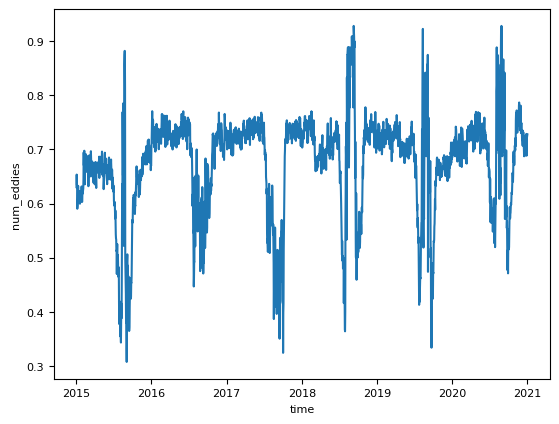

In [15]:
(ds_ce_cold.num_eddies/(ds_ce_cold.num_eddies+ds_ce_warm.num_eddies)).plot(x='time')

In [16]:
perc_cold_ce = (ds_ce_cold.num_eddies/(ds_ce_cold.num_eddies+ds_ce_warm.num_eddies))
perc_warm_ae = (ds_ae_warm.num_eddies/(ds_ae_cold.num_eddies+ds_ae_warm.num_eddies))


In [17]:
ice_avg = ds_ce_all.ice_avg.compute()


/p/project/chhb19/mueller29/miniconda3/envs/implicit_filter/lib/python3.9/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 12.63 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


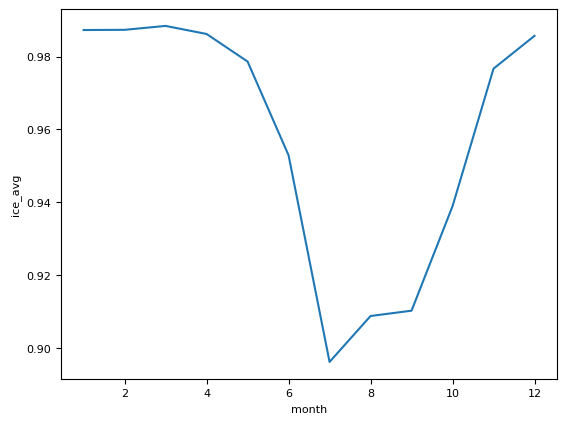

In [18]:
ice_avg['day_of_year'] = ice_avg['time.dayofyear']
ice_avg['month'] = ice_avg['time.month']
ice_avg.groupby('month').mean(dim='time').plot()

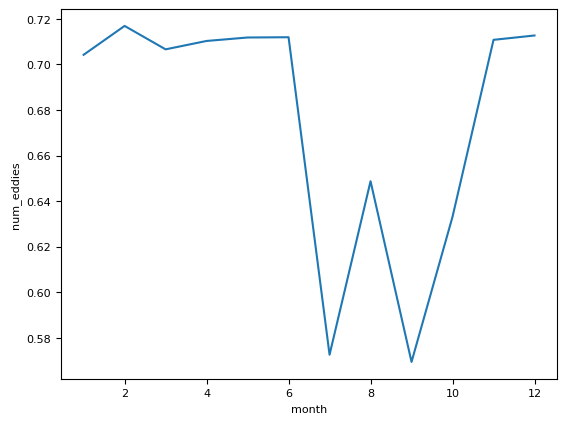

In [19]:
perc_cold_ce['day_of_year'] = perc_cold_ce['time.dayofyear']
perc_cold_ce['month'] = perc_cold_ce['time.month']
perc_cold_ce.groupby('month').mean(dim='time').plot()

In [20]:
ice_avg = ds_ae_all.ice_avg.compute()

/p/project/chhb19/mueller29/miniconda3/envs/implicit_filter/lib/python3.9/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 11.61 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


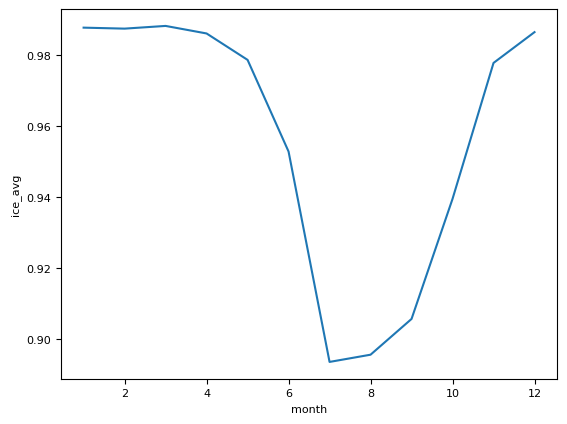

In [21]:
ice_avg['day_of_year'] = ice_avg['time.dayofyear']
ice_avg['month'] = ice_avg['time.month']
ice_avg.groupby('month').mean(dim='time').plot()

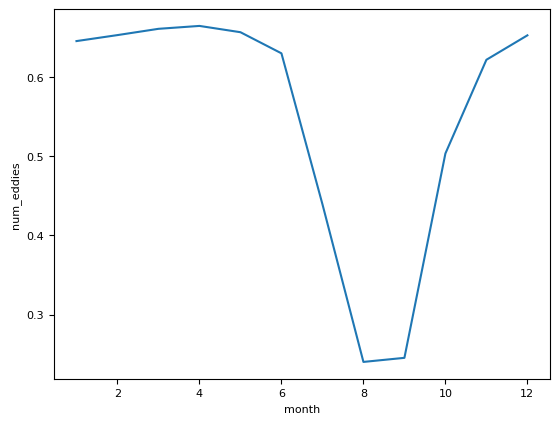

In [22]:
perc_warm_ae['day_of_year'] = perc_warm_ae['time.dayofyear']
perc_warm_ae['month'] = perc_warm_ae['time.month']
perc_warm_ae.groupby('month').mean(dim='time').plot()

In [23]:
s_ae_warm = ds_ae_warm['sum'].sum(dim='time').compute()
s_ce_warm = ds_ce_warm['sum'].sum(dim='time').compute()
ss_ae_warm = ds_ae_warm['square_sum'].sum(dim='time').compute()
ss_ce_warm = ds_ce_warm['square_sum'].sum(dim='time').compute()
n_ae_warm = ds_ae_warm['num_eddies'].sum(dim='time').compute()
n_ce_warm = ds_ce_warm['num_eddies'].sum(dim='time').compute()

s_ae_cold = ds_ae_cold['sum'].sum(dim='time').compute()
s_ce_cold = ds_ce_cold['sum'].sum(dim='time').compute()
ss_ae_cold = ds_ae_cold['square_sum'].sum(dim='time').compute()
ss_ce_cold = ds_ce_cold['square_sum'].sum(dim='time').compute()
n_ae_cold = ds_ae_cold['num_eddies'].sum(dim='time').compute()
n_ce_cold = ds_ce_cold['num_eddies'].sum(dim='time').compute()

ae_mean_warm = (s_ae_warm/n_ae_warm)
ce_mean_warm = (s_ce_warm/n_ce_warm)

ae_std_warm = (((ss_ae_warm/n_ae_warm)-ae_mean_warm**2))**.5
ce_std_warm = (((ss_ce_warm/n_ce_warm)-ce_mean_warm**2))**.5
ae_mean_cold = (s_ae_cold/n_ae_cold)
ce_mean_cold = (s_ce_cold/n_ce_cold)

ae_std_cold = (((ss_ae_cold/n_ae_cold)-ae_mean_cold**2))**.5
ce_std_cold = (((ss_ce_cold/n_ce_cold)-ce_mean_cold**2))**.5


if var == 'a_ice' or var == 'm_ice':
    ae_mean_warm *= 100
    ce_mean_warm *= 100
    ae_std_warm *= 100
    ce_std_warm *= 100
    ae_mean_cold *= 100
    ce_mean_cold *= 100
    ae_std_cold *= 100
    ce_std_cold *= 100
    

/p/project/chhb19/mueller29/miniconda3/envs/implicit_filter/lib/python3.9/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 10.70 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/p/project/chhb19/mueller29/miniconda3/envs/implicit_filter/lib/python3.9/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 10.94 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [24]:
test_statistic = (ae_mean_warm - 0) / (ae_std_warm / (n_ae_warm)**.5)
p_values_ae_warm = stats.t.sf(np.abs(test_statistic), n_ae_warm-1) * 2
test_statistic = (ce_mean_warm - 0) / (ce_std_warm / (n_ce_warm)**.5)
p_values_ce_warm = stats.t.sf(np.abs(test_statistic), n_ce_warm-1) * 2

test_statistic = (ae_mean_cold - 0) / (ae_std_cold / (n_ae_cold)**.5)
p_values_ae_cold = stats.t.sf(np.abs(test_statistic), n_ae_cold-1) * 2
test_statistic = (ce_mean_cold - 0) / (ce_std_cold / (n_ce_cold)**.5)
p_values_ce_cold = stats.t.sf(np.abs(test_statistic), n_ce_cold-1) * 2


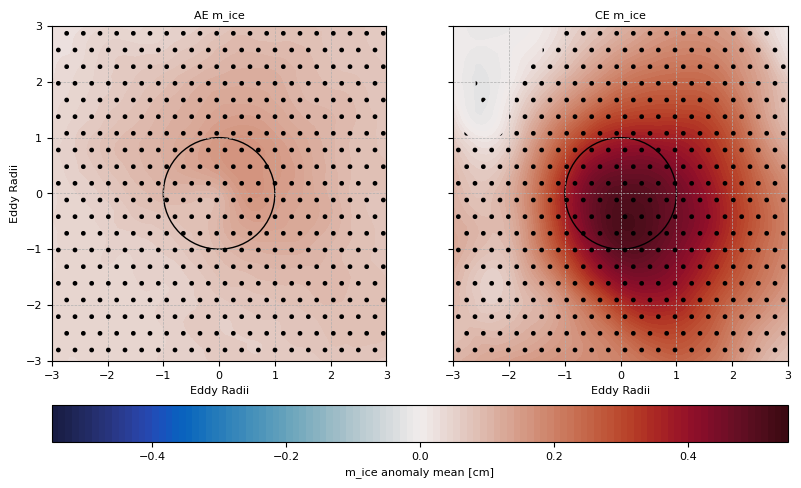

In [26]:
ae_mean = ae_mean_warm
ce_mean = ce_mean_cold
p_values_ae = p_values_ae_warm
p_values_ce = p_values_ce_cold


maxval,n = limits_for_levels(max([abs(ae_mean).max(),abs(ce_mean).max()]))

unit = units_dict.get(var)

bmin = -maxval
bmax = maxval
dstep = n

#bounds = np.arange(bmin,bmax+dstep,dstep).tolist()
bounds = np.linspace(bmin,bmax,dstep).tolist()

cmap = discrete_cmap(len(bounds)-1,cmocean.cm.balance)
norm = BoundaryNorm(bounds, cmap.N)



# Create a figure and axis
%matplotlib inline
cm2in = 1/2.54  # centimeters in inches
#figsize = (9.5*cm2in, 11.5*cm2in) #1/4 page
figsize = (9.5, 11.5) #1/4 page


fig, axs = plt.subplots(
            1,
            2,
            figsize=figsize,
            sharex=True,
            sharey=True
        )

ax=axs[0]
pc=ax.contourf(X,Y,ae_mean,cmap=cmap, norm=norm,levels=bounds,extend='neither', zorder=1)
p0=ax.contour(X,Y,ae_mean,colors='white',levels=[0], zorder=0)
psig=ax.contourf(X, Y, np.where(p_values_ae<0.05,1,np.nan), colors='none', hatches='.', zorder=3)


#ax.clabel(pc, fmt='%1.1f', inline=True, fontsize=10)

# Create a circle patch with center (x, y) and radius r
circle = Circle((0, 0), 1, edgecolor='k', facecolor='none',linewidth=1)
# Add the circle patch to the axis
ax.add_patch(circle)
ax.grid(True, linestyle='--', linewidth=0.5)
# Set aspect ratio to be equal to make the circle look like a circle
ax.set_aspect('equal', adjustable='box')
ax.set_title('AE '+var)

# Set limits for the plot
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_xlabel('Eddy Radii')
ax.set_ylabel('Eddy Radii')

ax=axs[1]
pc=ax.contourf(X,Y,ce_mean,cmap=cmap, norm=norm,levels=bounds,extend='neither', zorder=1)
p0=ax.contour(X,Y,ce_mean,colors='white',levels=[0], zorder=0)
psig=ax.contourf(X, Y, np.where(p_values_ce<0.05,1,np.nan), colors='none', hatches='......', zorder=3)


# Create a circle patch with center (x, y) and radius r
circle = Circle((0, 0), 1, edgecolor='k', facecolor='none',linewidth=1)
# Add the circle patch to the axis
ax.add_patch(circle)
ax.grid(True, linestyle='--', linewidth=0.5)

# Set aspect ratio to be equal to make the circle look like a circle
ax.set_aspect('equal', adjustable='box')
ax.set_title('CE '+var)

# Set limits for the plot
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_xlabel('Eddy Radii')
#ax.set_ylabel('Eddy Radii')

#colorbar
cbar=plt.colorbar(pc,ax=axs,orientation="horizontal", pad=.05,extend='neither')
cbar.ax.set_xscale('linear')
cbar.set_label(var+' anomaly mean ['+unit+']')

# Show the plot
plt.show()
#fig.savefig(plot_path + 'composite_'+var+'.png', dpi=600, format='png',bbox_inches='tight')

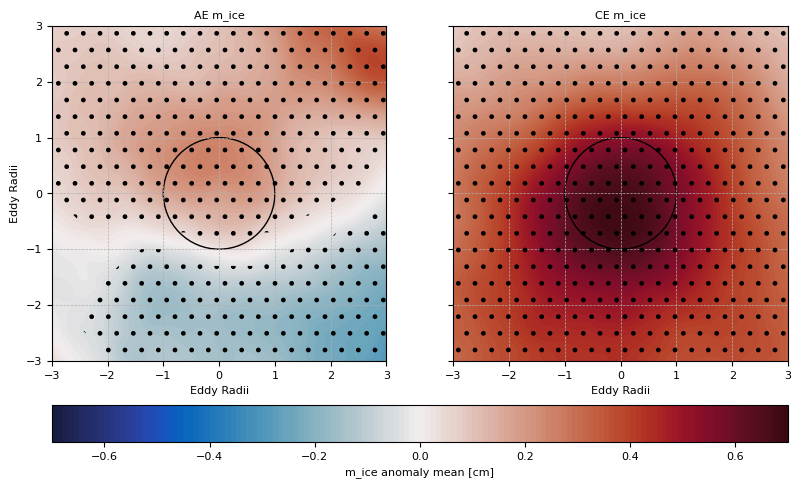

In [27]:
ae_mean = ae_mean_cold
ce_mean = ce_mean_warm
p_values_ae = p_values_ae_cold
p_values_ce = p_values_ce_warm



maxval,n = limits_for_levels(max([abs(ae_mean).max(),abs(ce_mean).max()]))

unit = units_dict.get(var)

bmin = -maxval
bmax = maxval
dstep = n

#bounds = np.arange(bmin,bmax+dstep,dstep).tolist()
bounds = np.linspace(bmin,bmax,dstep).tolist()

cmap = discrete_cmap(len(bounds)-1,cmocean.cm.balance)
norm = BoundaryNorm(bounds, cmap.N)



# Create a figure and axis
%matplotlib inline
cm2in = 1/2.54  # centimeters in inches
#figsize = (9.5*cm2in, 11.5*cm2in) #1/4 page
figsize = (9.5, 11.5) #1/4 page


fig, axs = plt.subplots(
            1,
            2,
            figsize=figsize,
            sharex=True,
            sharey=True
        )

ax=axs[0]
pc=ax.contourf(X,Y,ae_mean,cmap=cmap, norm=norm,levels=bounds,extend='neither', zorder=1)
p0=ax.contour(X,Y,ae_mean,colors='white',levels=[0], zorder=0)
psig=ax.contourf(X, Y, np.where(p_values_ae<0.05,1,np.nan), colors='none', hatches='.', zorder=3)


#ax.clabel(pc, fmt='%1.1f', inline=True, fontsize=10)

# Create a circle patch with center (x, y) and radius r
circle = Circle((0, 0), 1, edgecolor='k', facecolor='none',linewidth=1)
# Add the circle patch to the axis
ax.add_patch(circle)
ax.grid(True, linestyle='--', linewidth=0.5)
# Set aspect ratio to be equal to make the circle look like a circle
ax.set_aspect('equal', adjustable='box')
ax.set_title('AE '+var)

# Set limits for the plot
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_xlabel('Eddy Radii')
ax.set_ylabel('Eddy Radii')

ax=axs[1]
pc=ax.contourf(X,Y,ce_mean,cmap=cmap, norm=norm,levels=bounds,extend='neither', zorder=1)
p0=ax.contour(X,Y,ce_mean,colors='white',levels=[0], zorder=0)
psig=ax.contourf(X, Y, np.where(p_values_ce<0.05,1,np.nan), colors='none', hatches='......', zorder=3)


# Create a circle patch with center (x, y) and radius r
circle = Circle((0, 0), 1, edgecolor='k', facecolor='none',linewidth=1)
# Add the circle patch to the axis
ax.add_patch(circle)
ax.grid(True, linestyle='--', linewidth=0.5)

# Set aspect ratio to be equal to make the circle look like a circle
ax.set_aspect('equal', adjustable='box')
ax.set_title('CE '+var)

# Set limits for the plot
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_xlabel('Eddy Radii')
#ax.set_ylabel('Eddy Radii')

#colorbar
cbar=plt.colorbar(pc,ax=axs,orientation="horizontal", pad=.05,extend='neither')
cbar.ax.set_xscale('linear')
cbar.set_label(var+' anomaly mean ['+unit+']')

# Show the plot
plt.show()
#fig.savefig(plot_path + 'composite_'+var+'.png', dpi=600, format='png',bbox_inches='tight')

In [56]:
vars=['temp_0','temp_50','temp_100','temp_205']

/p/project/chhb19/mueller29/miniconda3/envs/implicit_filter/lib/python3.9/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 12.38 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/p/project/chhb19/mueller29/miniconda3/envs/implicit_filter/lib/python3.9/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 13.40 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/p/project/chhb19/mueller29/miniconda3/envs/implicit_filter/lib/python3.9/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 12.61 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/p/project/chhb19/mueller29/miniconda3/envs/implicit_filter/lib/python3.9/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 13.64 MiB.
This may caus

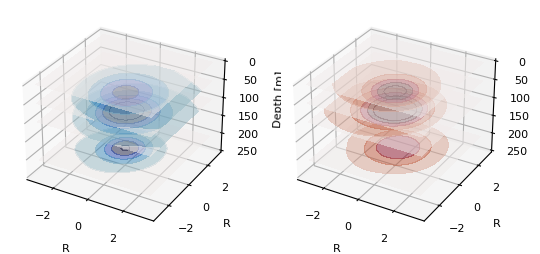

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

bmin = -.2
bmax = .2
dstep = 10

#bounds = np.arange(bmin,bmax+dstep,dstep).tolist()
bounds = np.linspace(bmin,bmax,dstep).tolist()

cmap = discrete_cmap(len(bounds)-1,cmocean.cm.balance)
norm = BoundaryNorm(bounds, cmap.N)

# Generate some sample data
x = reg_x
y = reg_y
X, Y = np.meshgrid(x, y)

# Define z levels for the slices
z_levels = [0, 50, 100, 205]

# Create the figure and the 3D plot
fig = plt.figure()
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

# Plot contour at each z-level
for z in z_levels:
#     var='temp_'+str(z)
#     ds_ae_all = xr.open_mfdataset(composite_path+var+'/new/composite_'+var+'*.nc', preprocess=functools.partial(preprocess,var=var,ice_min=ice_min,cyc=-1,region=region,rad_min=rad_min,rad_max=rad_max), combine='nested', concat_dim='time', parallel=True)
#     ds_ce_all = xr.open_mfdataset(composite_path+var+'/new/composite_'+var+'*.nc', preprocess=functools.partial(preprocess,var=var,ice_min=ice_min,cyc=1,region=region,rad_min=rad_min,rad_max=rad_max), combine='nested', concat_dim='time', parallel=True)
    
#     s_ae_all = ds_ae_all['sum'].sum(dim='time').compute()
#     s_ce_all = ds_ce_all['sum'].sum(dim='time').compute()
#     ss_ae_all = ds_ae_all['square_sum'].sum(dim='time').compute()
#     ss_ce_all = ds_ce_all['square_sum'].sum(dim='time').compute()
#     n_ae_all = ds_ae_all['num_eddies'].sum(dim='time').compute()
#     n_ce_all = ds_ce_all['num_eddies'].sum(dim='time').compute()

#     ae_mean_all = (s_ae_all/n_ae_all)
#     ce_mean_all = (s_ce_all/n_ce_all)
    
    ax1.contourf(X, Y, ce_mean_all, zdir='z', offset=z, alpha=0.5,cmap=cmap, norm=norm,levels=bounds,extend='both')
    ax2.contourf(X, Y, ae_mean_all, zdir='z', offset=z, alpha=0.5,cmap=cmap, norm=norm,levels=bounds,extend='both')

# Add labels
ax1.set_xlabel('R')
ax1.set_ylabel('R')
ax1.set_zlabel('Depth [m]')
ax1.set_zlim(250, 0)


ax2.set_xlabel('R')
ax2.set_ylabel('R')
ax2.set_zlabel('Depth [m]')
ax2.set_zlim(250, 0)


# Show the plot
plt.show()


/p/project/chhb19/mueller29/miniconda3/envs/implicit_filter/lib/python3.9/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 12.38 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/p/project/chhb19/mueller29/miniconda3/envs/implicit_filter/lib/python3.9/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 13.40 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/p/project/chhb19/mueller29/miniconda3/envs/implicit_filter/lib/python3.9/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 12.61 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/p/project/chhb19/mueller29/miniconda3/envs/implicit_filter/lib/python3.9/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 13.64 MiB.
This may caus

ValueError: alpha (4) is outside 0-1 range

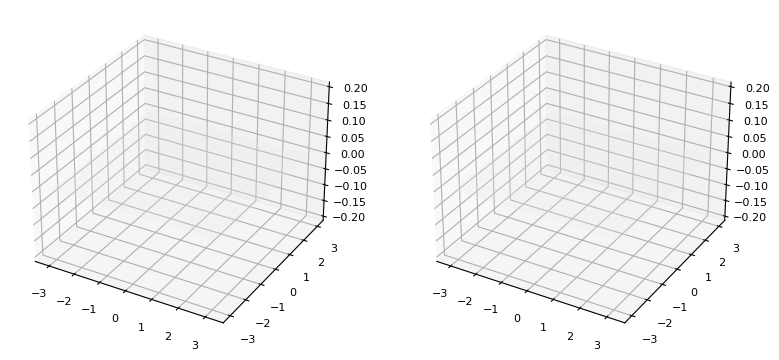

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
cm2in = 1/2.54  # centimeters in inches
figsize = (9.5, 11.5) #1/4 page

#maxval,n = limits_for_levels(max([abs(ae_mean_all).max(),abs(ce_mean_all).max()]))

bmin = -.2
bmax = .2
dstep = 41

#bounds = np.arange(bmin,bmax+dstep,dstep).tolist()
bounds = np.linspace(bmin,bmax,dstep).tolist()

cmap = discrete_cmap(len(bounds)-1,cmocean.cm.balance)
norm = BoundaryNorm(bounds, cmap.N)

# Generate some sample data
x = reg_x
y = reg_y
X, Y = np.meshgrid(x, y)

# Define z levels for the slices
z_levels = [0, 50, 100, 205]
alphas = [0.2,0,4,0.6,1]

# Create the figure and the 3D plot
fig = plt.figure(figsize=figsize)
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

# Plot contour at each z-level
for dd,z in enumerate(z_levels):
    var='temp_'+str(z)
    ds_ae_all = xr.open_mfdataset(composite_path+var+'/new/composite_'+var+'*.nc', preprocess=functools.partial(preprocess,var=var,ice_min=ice_min,cyc=-1,region=region,rad_min=rad_min,rad_max=rad_max), combine='nested', concat_dim='time', parallel=True)
    ds_ce_all = xr.open_mfdataset(composite_path+var+'/new/composite_'+var+'*.nc', preprocess=functools.partial(preprocess,var=var,ice_min=ice_min,cyc=1,region=region,rad_min=rad_min,rad_max=rad_max), combine='nested', concat_dim='time', parallel=True)
    
    s_ae_all = ds_ae_all['sum'].sum(dim='time').compute()
    s_ce_all = ds_ce_all['sum'].sum(dim='time').compute()
    ss_ae_all = ds_ae_all['square_sum'].sum(dim='time').compute()
    ss_ce_all = ds_ce_all['square_sum'].sum(dim='time').compute()
    n_ae_all = ds_ae_all['num_eddies'].sum(dim='time').compute()
    n_ce_all = ds_ce_all['num_eddies'].sum(dim='time').compute()

    ae_mean_all = (s_ae_all/n_ae_all)
    ce_mean_all = (s_ce_all/n_ce_all)
    alpha = 0.004*z + 0.2
    cp1=ax1.contourf(X, Y, ce_mean_all, zdir='z', offset=z, alpha=alphas[dd],cmap=cmap, norm=norm,levels=bounds,extend='both')
    cp2=ax2.contourf(X, Y, ae_mean_all, zdir='z', offset=z, alpha=alphas[dd],cmap=cmap, norm=norm,levels=bounds,extend='both')

# Add labels
ax1.set_xlabel('R')
ax1.set_ylabel('R')
ax1.set_zlabel('Depth [m]')
ax1.set_zlim(250, 0)
ax1.set_xlim(-3, 3)
ax1.set_ylim(-3, 3)

ax2.set_xlabel('R')
ax2.set_ylabel('R')
ax2.set_zlabel('Depth [m]')
ax2.set_zlim(250, 0)
ax2.set_xlim(-3, 3)
ax2.set_ylim(-3, 3)


cbar=plt.colorbar(cp1,ax=[ax1,ax2],orientation="horizontal", pad=.05,extend='both')

# Show the plot
plt.show()
fig.savefig(plot_path + 'composite_temp3D.png', dpi=600, format='png',bbox_inches='tight')

In [12]:
a=1